<a href="https://colab.research.google.com/github/Basel-byte/Speech-Emotion-Recognition/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from scipy.io import wavfile
from sklearn.preprocessing import LabelBinarizer
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Crema.zip -d /content/drive/MyDrive

In [31]:
dir_path = "/content/drive/MyDrive/Crema"
labels = []
audio_waves = []
for file_name in os.listdir(dir_path):
  labels.append(file_name[9:12])
  audio_waves.append(librosa.load(os.path.join(dir_path, file_name)))
print(labels)
lb = LabelBinarizer()
encoded_labels = lb.fit_transform(labels)
print(encoded_labels)
lb.classes_

['FEA', 'DIS', 'ANG', 'SAD', 'HAP', 'ANG', 'NEU', 'DIS', 'NEU', 'HAP', 'HAP', 'FEA', 'FEA', 'SAD', 'ANG', 'HAP', 'DIS', 'SAD', 'ANG', 'SAD', 'FEA', 'HAP', 'NEU', 'ANG', 'ANG', 'FEA', 'SAD', 'NEU', 'DIS', 'HAP', 'DIS', 'SAD', 'DIS', 'ANG', 'FEA', 'ANG', 'NEU', 'FEA', 'DIS', 'NEU', 'SAD', 'FEA', 'HAP', 'DIS', 'FEA', 'DIS', 'NEU', 'HAP', 'NEU', 'ANG', 'DIS', 'ANG', 'FEA', 'HAP', 'HAP', 'FEA', 'SAD', 'DIS', 'SAD', 'ANG', 'SAD', 'ANG', 'FEA', 'DIS', 'DIS', 'HAP', 'NEU', 'HAP', 'DIS', 'ANG', 'SAD', 'NEU', 'ANG', 'ANG', 'SAD', 'HAP', 'NEU', 'HAP', 'SAD', 'NEU', 'FEA', 'SAD', 'HAP', 'NEU', 'FEA', 'FEA', 'DIS', 'ANG', 'SAD', 'HAP', 'HAP', 'NEU', 'DIS', 'ANG', 'SAD', 'SAD', 'NEU', 'DIS', 'DIS', 'DIS', 'NEU', 'SAD', 'HAP', 'SAD', 'SAD', 'DIS', 'SAD', 'SAD', 'FEA', 'NEU', 'NEU', 'ANG', 'ANG', 'FEA', 'NEU', 'SAD', 'ANG', 'FEA', 'ANG', 'DIS', 'SAD', 'SAD', 'FEA', 'NEU', 'HAP', 'ANG', 'HAP', 'HAP', 'ANG', 'DIS', 'DIS', 'DIS', 'NEU', 'HAP', 'ANG', 'ANG', 'DIS', 'DIS', 'ANG', 'HAP', 'FEA', 'SAD', 'DIS'

array(['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'], dtype='<U3')

In [46]:
data = []
for audio in audio_waves:
  librosa_audio, librosa_sample_rate = audio
  mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
  data.append(mfccs)

22050
(40, 94)


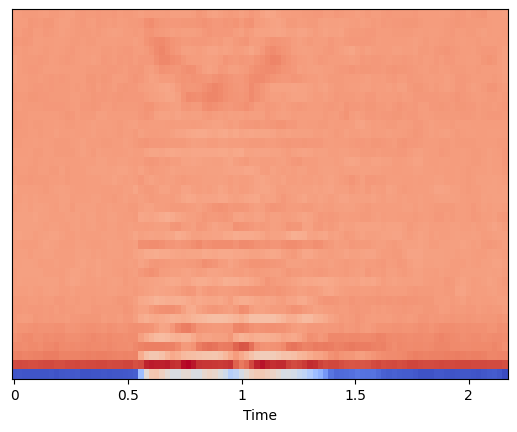

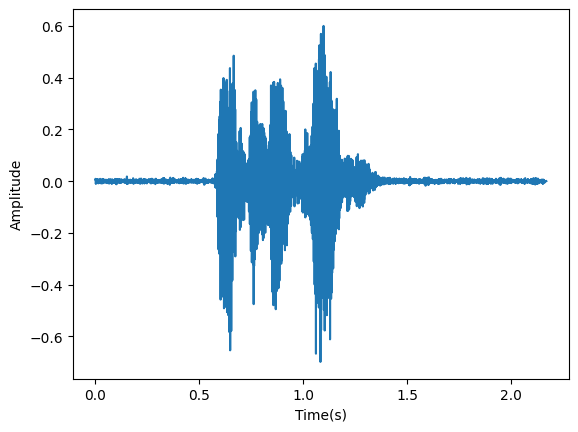

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,-471.382355,-470.074310,-473.144745,-472.761780,-472.446167,-471.697601,-473.316559,-471.070190,-475.175537,-470.944427,...,-472.319366,-470.932129,-470.373260,-473.252045,-473.701599,-470.462524,-464.806000,-462.734558,-468.710785,-486.365601
1,105.913292,108.831810,106.309464,104.044830,105.403687,107.853119,110.071259,110.803314,104.065811,105.366653,...,112.131691,111.348785,111.290192,109.538429,109.067993,109.162430,107.223755,107.630264,107.814186,101.457657
2,35.017483,37.415825,33.148975,34.641426,38.441414,37.171902,42.447441,43.739296,42.456802,37.088676,...,43.840294,41.923626,38.918777,40.230389,40.552990,38.074371,30.221321,30.766811,34.113388,33.156792
3,22.620480,22.702362,21.622868,25.047150,24.722498,20.747847,27.595905,29.355492,32.097530,26.428612,...,25.589958,23.661388,23.174442,25.942715,25.975723,25.027351,26.653679,30.041183,26.267076,15.244062
4,13.506096,17.605295,23.389450,24.683874,19.116259,17.690495,22.566967,21.342098,22.822182,22.752632,...,21.929131,17.583138,21.126242,23.488897,22.820297,19.358025,21.664032,22.796959,22.012459,20.753260
5,6.394736,9.293500,10.039976,12.353609,15.402150,13.258280,11.990772,13.437922,15.744059,15.628641,...,18.464071,16.030087,18.076153,16.447443,16.345953,15.677822,11.238221,9.478300,16.965565,16.318626
6,2.209568,-1.066335,-3.570770,-1.312611,5.235947,2.017033,1.007467,4.132137,1.098601,0.812300,...,4.824087,5.960185,7.562006,5.361288,2.586590,6.439331,4.864252,4.590507,9.862572,4.666509
7,4.052350,1.677117,0.845647,3.144567,2.788717,1.648222,1.110895,1.877015,-1.268069,2.524116,...,1.332539,0.901283,3.161885,1.772523,-2.378649,0.048720,1.623218,1.540068,-0.350957,-3.520792
8,1.511638,1.346262,-0.203421,-2.449500,-3.265990,-0.531419,-1.475695,-2.774470,1.611752,2.173088,...,-2.519924,-6.306198,-0.520338,-1.588339,-5.425601,-1.207165,-1.283569,-5.389254,-6.652640,-6.862359
9,-4.852870,-4.064092,-5.194749,-7.703908,-4.917159,-3.138836,-8.270974,-10.019399,-6.115413,-2.310114,...,-11.369772,-14.071712,-6.836999,-1.823764,-5.713307,-3.754618,-7.330840,-9.502838,-5.904529,-2.847636


In [43]:
librosa_audio, librosa_sample_rate = audio_waves[0]
print(librosa_sample_rate)
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
time = np.arange(0,len(librosa_audio)) / librosa_sample_rate
fig, ax = plt.subplots()
ax.plot(time, librosa_audio)
ax.set(xlabel='Time(s)',ylabel='Amplitude')
plt.show()
df = pd.DataFrame(mfccs)
df